## Taking Derivatives of Noisy Data

We can estimate derivatives numerically as $\Delta V / \Delta t = \frac{V_1-V_0}{t_1-t_0}$ which will be mathematically correct as the differences become small. Unfortunately the relative uncertainties in those differences will become enormous as the differences become small, so we need to balance the length of the time step $\Delta t$ that we use for calculation.

In [2]:
# gets all of numpy but you will still need to refer to e.g. numpy.random.randn() as random.randn()
from numpy import *               # all of the array capable elements for numerical data          
from scipy.stats import norm      # comprehensive functions for Gaussian normal distributions
import csv                        # library for reading and writing comma separated value files
from matplotlib.pyplot import *   # all of pyplot to graph the results of our calculations

# put figures inline in the notebook, so you don't have to call show()
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
#figsize(14, 7)

## Numerical differentiation works very well on clean, evenly timed data
Assume your code is reading a value at `rate` samples per second and `tNom` is an array of the nominal, evenly spaced reading times.

Define a function to estimate the derivatives based on a simple difference $\Delta v / \Delta t$ and compare results for accurate values of v(t) and t. This is the simplest estimator applied to the simplest sampling situation!

[0, 1, -75, 175]

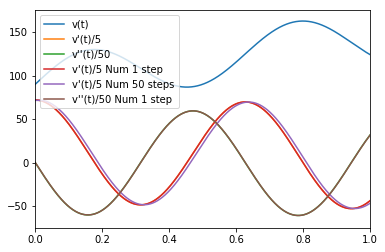

In [6]:
def value(s):           # A function and it's first and second derivatives, analytically 
    v = 90
    v += 60 * sin(s)
    v += 30 * sin(10 * s)
    return v

def dvdt(s):
    d = 60 * cos(s)
    d += 30 * 10 * cos(10 * s)
    return d

def d2vdt(s):
    d = -60 * sin(s)
    d += -30 * 10 * 10 * sin(10 * s)
    return d

def dvdtDiff(t,v,steps = 1):    # First derivative of data by delta v / delta t
    dv = zeros(len(t))          # Look back by steps time steps in the samples
    for i in range(0,len(t)):
        if(i<steps): j = steps  # start gracefully - estimate as first calculable
        else: j = i
        dv[i] = (v[j]-v[j-steps])/(t[j]-t[j-steps])
    return dv

st = 3                        # sample time in seconds
rate = 2347.345678912345      # approximate sample rate
tNom = linspace(0,st,int(rate*st)) # st seconds of sampling at rate


plot(tNom,value(tNom),label = "v(t)")
plot(tNom,dvdt(tNom)/5, label = "v'(t)/5")
plot(tNom,d2vdt(tNom)/50, label = "v''(t)/50")
plot(tNom,dvdtDiff(tNom,value(tNom),1)/5,label = "v'(t)/5 Num 1 step")
plot(tNom,dvdtDiff(tNom,value(tNom),50)/5,label = "v'(t)/5 Num 50 steps")
plot(tNom,dvdtDiff(tNom,dvdtDiff(tNom,value(tNom),1),1)/50,label = "v''(t)/50 Num 1 step")
legend()
axis([0,1,-75,175])
#axis([0,0.002,71.99,72.01])

The numerical results follow the analytical results very accurately, but will lag if the step size is too long.

## Variable times between samples doesn't change things much
Assume your code is reading a value at **about** `rate` samples per second, with a variability of `varCyc` clock cycles each period because of different execution paths in the code (e.g. if statements with different calculations).

`tNom` is an array of the nominal, evenly spaced reading times, while `t` is the actual times that the reading was taken, forced to be an even number of clock cycles and with a random variation in period.

[0, 1, -75, 175]

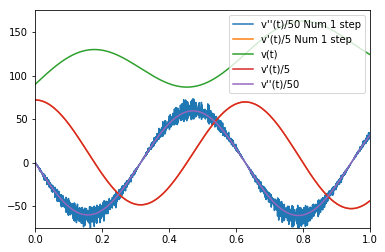

In [7]:
clock = 16000000        # cycles of the clock per second
varCyc = clock/rate     # clock ticks per cycle through sample loop
varCyc /= 4             # make variability a fraction of a cycle (try different fractions)

t = tNom.copy()
t = floor(t*clock)      # discrete clock steps at 16 MHz
t = t + random.randint(0,varCyc,len(t))
t /= clock              # back into seconds
v = value(t)            # get the values for the actual time

plot(t,dvdtDiff(t,dvdtDiff(t,v,1),1)/50,label = "v''(t)/50 Num 1 step")
plot(t,dvdtDiff(t,v,1)/5,label = "v'(t)/5 Num 1 step")
#plot(t,dvdtDiff(t,v,50)/5,label = "v'(t)/5 Num 50 steps")
plot(t,v,label = "v(t)")
plot(t,dvdt(t)/5, label = "v'(t)/5")
plot(t,d2vdt(t)/50, label = "v''(t)/50")
legend()
axis([0,1,-75,175])

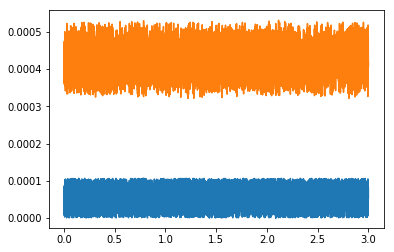

In [8]:
plot(t,(t-tNom))                # shows that t is never very far from tNom
plot(t[1:], t[1:]-t[:len(t)-1]) # and delta t is always positive

## micros() and millis() aren't accurate

Both of these functions return unsigned long integers which have limited resolution and always lag behind the real time. On the UNO, micros() only ticks over to a new value every 64 clock cycles, which is every 4 us at 16 MHz clock frequency. In addition, millis() has a "leap millisecond" problem because it only ticks over to a new millisecond value every 256 micros() ticks, or every 1024 microseconds. The millis value needs to be increased by one extra millisecond about every 24th of a second. This code provides a good approximation of the approximate times returned by micros() and millis() on the UNO for any actual time in seconds. (Other micro-controller platforms will have different timing characteristics!)

**Note that the values are not accurate and that they follow a pattern that is not random!**

In [9]:
def tMicros(s):
    # Translate a real time in seconds to the time that would be 
    # returned by micros() also in seconds. The micros() function 
    # returns integer values that change accurately every 4 us
    # e.g. 1004, 1008, 1012, 1016, etc., anywhere from 0 to <4 us behind
    t = floor(s * 1000000 / 4)     # number of 4 us steps
    return t / 250000.             # value in seconds

def tMillis(s):
    # Translate a real time in seconds to the time that would be 
    # returned by millis() also in seconds. The millis() function 
    # returns integer values that fall behind at a rate of 1024/1000 
    # and need to be updated every 24th of a second with a 
    # "leap millisecond". Anywhere from 0 to 2 ms behind.
    
    t1 = floor(s * 24) / 24        # last round 24th of a second
    t1 = floor(t1 * 1000) / 1000.  # in even milliseconds
    t2 = (s - t1) * 1000 / 1024.   # time since, slowed
    t2 = floor(t2 * 1000) / 1000.  # in even milliseconds
    return t1+t2                   # value in seconds

`tm` and `tu` are the corresponding times reported by the millis() and micros() functions at the actual times `t`. All values are still in seconds.

[0, 0.5, -5e-05, 0.002]

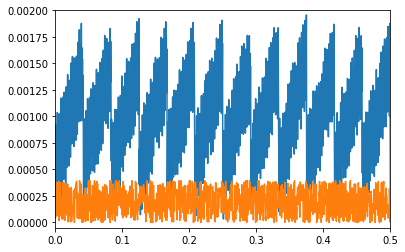

In [10]:
tm = tMillis(t)
tu = tMicros(t)
plot(t, t-tm)
plot(t, (t-tu)*100)         # scaled to make it visible
axis([0,0.5,-.00005,.002])

## Derivatives with ideal data and a real time base

We can now look at the results for our derivatives if we use the real timebase that would be returned by either the millis() or micros() functions. It is no surprise that the results we get with millis() are badly compromised, even if we only look at the first derivative. Even the results from the micros() timebase have substantial noise on them and we would like them to be smoother.

[0, 1, -75, 175]

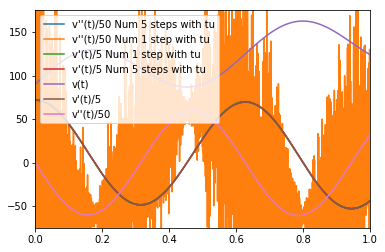

In [11]:
plot(tu,dvdtDiff(tu,dvdtDiff(tu,v,5),5)/50,label = "v''(t)/50 Num 5 steps with tu")
plot(tu,dvdtDiff(tu,dvdtDiff(tu,v,1),1)/50,label = "v''(t)/50 Num 1 step with tu")
#plot(tm,dvdtDiff(tm,v,7)/5,label = "v'(t)/5 Num 13 step with tm")
plot(tu,dvdtDiff(tu,v,1)/5,label = "v'(t)/5 Num 1 step with tu")
plot(tu,dvdtDiff(tu,v,5)/5,label = "v'(t)/5 Num 5 steps with tu")
plot(tu,value(tu),label = "v(t)")
plot(tu,dvdt(tu)/5, label = "v'(t)/5")
plot(tu,d2vdt(tu)/50, label = "v''(t)/50")
legend()
axis([0,1,-75,175])



## Add some smoothing into the process
We are adding noise at every stage of the processing, so it would make sense to smooth the data at each stage as well. In this code we use our previous exponential smoothing function (easy to implement on Arduino) to smooth the input before each call the the differentiation function. The results are much better!

[0, 1, -75, 175]

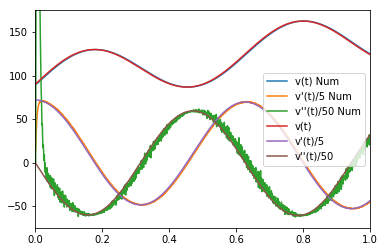

In [12]:
def expSmooth(t,T,tau):        # returns a smoothed version of T with time constant tau
    Ts = T.copy()              # another vector for the smoothed data
    for i in range(1,len(Ts)): # here's where the actual smoothing happens
        dt = t[i]-t[i-1]
        w = min(dt/tau,1)
        Ts[i] = Ts[i-1] * (1-w) + T[i] * w
    return Ts                  # return the smoothed data

vs = expSmooth(tu,v,.004)
vp = dvdtDiff(tu,vs,3)
vps = expSmooth(tu,vp,0.004)
vpp = dvdtDiff(tu,vps,3)

plot(tu,vs,label = "v(t) Num")
plot(tu,vp/5,label = "v'(t)/5 Num")
plot(tu,vpp/50,label = "v''(t)/50 Num")
plot(tu,value(tu),label = "v(t)")
plot(tu,dvdt(tu)/5, label = "v'(t)/5")
plot(tu,d2vdt(tu)/50, label = "v''(t)/50")

legend()
axis([0,1,-75,175])



## Now with actual noisy data vaues

Everything so far has been calculated with perfect data values that exactly match our original function. If we had acquired that data with our Arduino UNO, it would be resolution limited to 10 bits (0-1023) and would have some noise from the circuit and the conversion process. This function simulates the effects of running the values through the ADC process. It converts the values into an unsigned integer that would result from analogRead() with some conversion noise, then converts it back into the equivalent floating point number with the effects of noise and limited resolution incorporated in the results.

[0, 0.1, 90, 120]

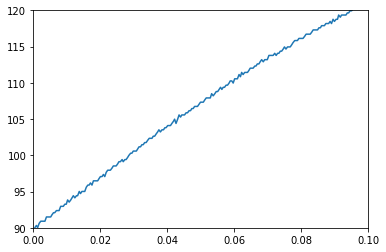

In [13]:
def adc(v,offset,range,bits = 10):
    vv = v.copy()
    m = (2**bits-1)                    # 1023 for the 10 bit values
    vv = (v - offset)/range * m        # get the binary representation as a float
    vv += random.randn(len(vv)) * 0.5  # add some conversion noise
    vv = floor(vv)                     # round down to nearest int
    vv = maximum(vv,zeros(len(vv)))    # make sure it isn't out of bounds
    vv = minimum(vv,ones(len(vv))*m)
    vv = vv / m * range + offset       # convert back to the original units
    return vv

vv = adc(v,0,300)
plot(t,vv)
axis([0,0.1,90,120])

## Repeat the process with the noisy data

The same approaches help reduce the differentiation noise resulting from noise in the data as worked for noise in the time base.

[0, 1, -75, 175]

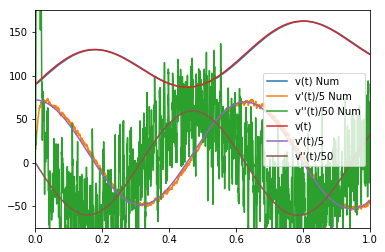

In [14]:
vs = expSmooth(tu,vv,0.004)
vp = dvdtDiff(tu,vs,1)
vps = expSmooth(tu,vp,0.004)
vpp = dvdtDiff(tu,vps,1)
vpps = expSmooth(tu,vpp,0.004)  # smooth the acceleration too!

plot(tu,vs,label = "v(t) Num")
plot(tu,vps/5,label = "v'(t)/5 Num")
plot(tu,vpps/50,label = "v''(t)/50 Num")
plot(tu,value(tu),label = "v(t)")
plot(tu,dvdt(tu)/5, label = "v'(t)/5")
plot(tu,d2vdt(tu)/50, label = "v''(t)/50")

legend()
axis([0,1,-75,175])
